# EMA RSI Strategy

Winning ideas:
- Hour timeframe
- mean reverting stocks

In [1]:
from datetime import datetime, timedelta
import logging
import pytz
import pandas as pd

from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
import pandas as pd
from talib import ATR, EMA, RSI

from examples.data import (
    download_bars,
    separate_bars_by_symbol,
    split_multi_index_bars_train_test,
)

from bacta.backtester import EventBacktester, Order, Position
from bacta.utilities import dash
from bacta.utilities.logger import get_logger, set_log_level
logger = get_logger()
set_log_level(logging.DEBUG)

/usr/local/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class EmaStrategy(EventBacktester):
    """
    Backtester that uses the Keltner Channel to make decisions.
    """

    def __init__(self, active_symbols, cash, **kwargs):
        super().__init__(active_symbols, cash, **kwargs)
        stretch = 1
        self.short_ema_period = 21 * stretch
        self.long_ema_period = 200 * stretch
        self.rsi_period = 14 * stretch
        self.rsi_high = 65
        self.rsi_low = 35
        self.max_position_value = 700

    def precompute_step(self, bars: pd.DataFrame):
        """
        Preload the indicators for the backtest.
        """

        split_bars = separate_bars_by_symbol(bars)

        self.short_emas = {
            symbol: EMA(
                split_bars[symbol].loc[:,
                                       "close"], timeperiod=self.short_ema_period
            )
            for symbol in self.active_symbols
        }
        self.long_emas = {
            symbol: EMA(
                split_bars[symbol].loc[:,
                                       "close"], timeperiod=self.long_ema_period
            )
            for symbol in self.active_symbols
        }
        self.rsis = {
            symbol: RSI(split_bars[symbol].loc[:, "close"],
                        timeperiod=self.rsi_period)
            for symbol in self.active_symbols
        }

    def update_step(self, bars: pd.DataFrame, index: pd.Timestamp):
        """
        Update the state of the backtester.
        """
        split_bars = separate_bars_by_symbol(bars)

        self.short_emas = {
            symbol: EMA(
                split_bars[symbol].loc[:,
                                       "close"], timeperiod=self.short_ema_period
            )
            for symbol in self.active_symbols
        }
        self.long_emas = {
            symbol: EMA(
                split_bars[symbol].loc[:,
                                       "close"], timeperiod=self.long_ema_period
            )
            for symbol in self.active_symbols
        }
        self.rsis = {
            symbol: RSI(split_bars[symbol].loc[:, "close"],
                        timeperiod=self.rsi_period)
            for symbol in self.active_symbols
        }

    def generate_orders(self, bar: pd.DataFrame, index: pd.Timestamp) -> list[Order]:
        """
        Make a decision based on the prices.
        """
        close_prices = bar.loc[:, "close"]
        # short ema is 21, long ema is 200
        # rsi is 14
        # if rsi is > 75 and short ema is > long ema, then short
        # if rsi is < 25 and short ema is < long ema, then long
        orders = []

        for symbol in self.active_symbols:
            position_value = abs(self.get_position(symbol)*close_prices[symbol]) if self.get_position(symbol) != 0 else 0
            quantity = round(200 / close_prices[symbol], 4)
            if (
                self.rsis[symbol][index] > self.rsi_high
                and self.short_emas[symbol][index] > self.long_emas[symbol][index]
            ) and position_value < self.max_position_value:
                orders.append(
                    Order(symbol, Position.SHORT,
                          close_prices[symbol], quantity)
                )
            elif (
                self.rsis[symbol][index] < self.rsi_low
                and self.short_emas[symbol][index] < self.long_emas[symbol][index]
            ) and position_value < self.max_position_value:
                orders.append(
                    Order(symbol, Position.LONG,
                          close_prices[symbol], quantity)
                )

        return orders


In [3]:
symbols = ["DUK", "LLY", "AEP"]

shift = - timedelta(days=1)
bars = download_bars(
    symbols,
    start_date=datetime(2025, 4, 1) - shift,
    end_date=datetime(2025, 7, 1) - shift,
    timeframe=TimeFrame(1, TimeFrameUnit.Hour)
)
# split the bars into train and test
train_bars, test_bars = split_multi_index_bars_train_test(
    bars, split_ratio=0.2)
    
# create the backtester
backtester = EmaStrategy(
    symbols,
    cash=2000,
    allow_short=True,
    allow_overdraft=False,
    min_cash_balance=200,
    min_trade_value=1,
    market_hours_only=True,
    transaction_cost=0.000,
    transaction_cost_type="percentage",
)

# preload the train bars
backtester.load_train_bars(train_bars)

# run_backtest the backtest
backtester.run_backtest(test_bars)

# plot the order and state history
print(dash("order history"))
print(backtester.get_history())
print(dash("state history"))
print(backtester.get_state_history())

[2025-08-17 20:13:24][DEBUG] Loading data/DUKLLYAEP_2025-04-02_2025-07-02_1Hour.pkl
[2025-08-17 20:13:24][DEBUG] Initializing backtester with active symbols: ['DUK', 'LLY', 'AEP'], cash: 2000, allow_short: True, allow_overdraft: False, min_cash_balance: 200, min_trade_value: 1, market_hours_only: True
[2025-08-17 20:13:24][INFO] Train bars have been previously loaded. Concatenating with test bars...
[2025-08-17 20:13:24][INFO] Running backtest over 6074 bars from 2025-04-20 09:00:00-04:00 to 2025-07-01 16:00:00-04:00...
[2025-08-17 20:13:24][DEBUG] Placing LONG 1.6942 DUK @ $118.050 (2025-04-21 15:00:00-04:00)
[2025-08-17 20:13:24][DEBUG] Placing LONG 1.6939 DUK @ $118.070 (2025-04-21 16:00:00-04:00)
[2025-08-17 20:13:24][DEBUG] Placing LONG 1.9279 AEP @ $103.740 (2025-04-21 16:00:00-04:00)
[2025-08-17 20:13:24][DEBUG] Placing SHORT 1.8816 AEP @ $106.290 (2025-04-22 11:00:00-04:00)
[2025-08-17 20:13:24][DEBUG] Placing SHORT 1.89 AEP @ $105.820 (2025-04-22 12:00:00-04:00)
[2025-08-17 20

- order history ----------------------------------------------------------------
                          symbol  position   price  quantity
2025-04-21 15:00:00-04:00    DUK         1  118.05    1.6942
2025-04-21 16:00:00-04:00    DUK         1  118.07    1.6939
2025-04-21 16:00:00-04:00    AEP         1  103.74    1.9279
2025-04-22 11:00:00-04:00    AEP        -1  106.29    1.8816
2025-04-22 12:00:00-04:00    AEP        -1  105.82    1.8900
2025-04-22 14:00:00-04:00    AEP        -1  105.91    1.8884
2025-04-22 15:00:00-04:00    AEP        -1  106.28    1.8818
2025-04-22 16:00:00-04:00    AEP        -1  106.32    1.8811
2025-04-24 10:00:00-04:00    LLY        -1  847.41    0.2360
2025-04-24 11:00:00-04:00    LLY        -1  847.18    0.2361
2025-04-24 12:00:00-04:00    LLY        -1  851.36    0.2349
2025-04-24 13:00:00-04:00    LLY        -1  852.53    0.2346
2025-04-29 10:00:00-04:00    DUK        -1  119.44    1.6745
2025-04-29 11:00:00-04:00    DUK        -1  119.16    1.6784
2025

In [4]:
# plot the performance
print(dash("performance"))
print(backtester.pretty_format_performance())

[2025-08-17 20:13:30][INFO] Auto-calculated periods per year: 8766 (avg time diff: 3600.0 seconds)


- performance ------------------------------------------------------------------
Backtest Performance:
- Return on Investment: 9.90%
- vs. Buy and Hold Return: -3.66%
- Sharpe Ratio: 2.35
- Max Drawdown Percentage: 4.91%

- Start Portfolio Value: $2000.00
- End Portfolio Value: $2197.91
- Min Portfolio Value: $1942.74
- Max Portfolio Value: $2286.99
- Min Cash Balance: $1400.00
- Max Cash Balance: $4399.98
- Win Rate: 100.00%

- Number of Orders: 29
- Avg Orders per Day: 0.40
- Number of Winning Trades: 26
- Number of Losing Trades: 0
- Avg Trade Return: 5.53%
- Largest Win: 13.03% ($25.92)
- Largest Loss: 0.00% ($0.02)
- Max Consecutive Wins: 1
- Max Consecutive Losses: 1

- Trading Period Start: 2025-04-20 09:00:00-04:00
- Trading Period End: 2025-07-01 16:00:00-04:00
- Trading Period Length: 72 days 07:00:00
- Time in Market: 98.16%


[2025-08-17 20:13:30][INFO] Auto-calculated periods per year: 8766 (avg time diff: 3600.0 seconds)


plotting...


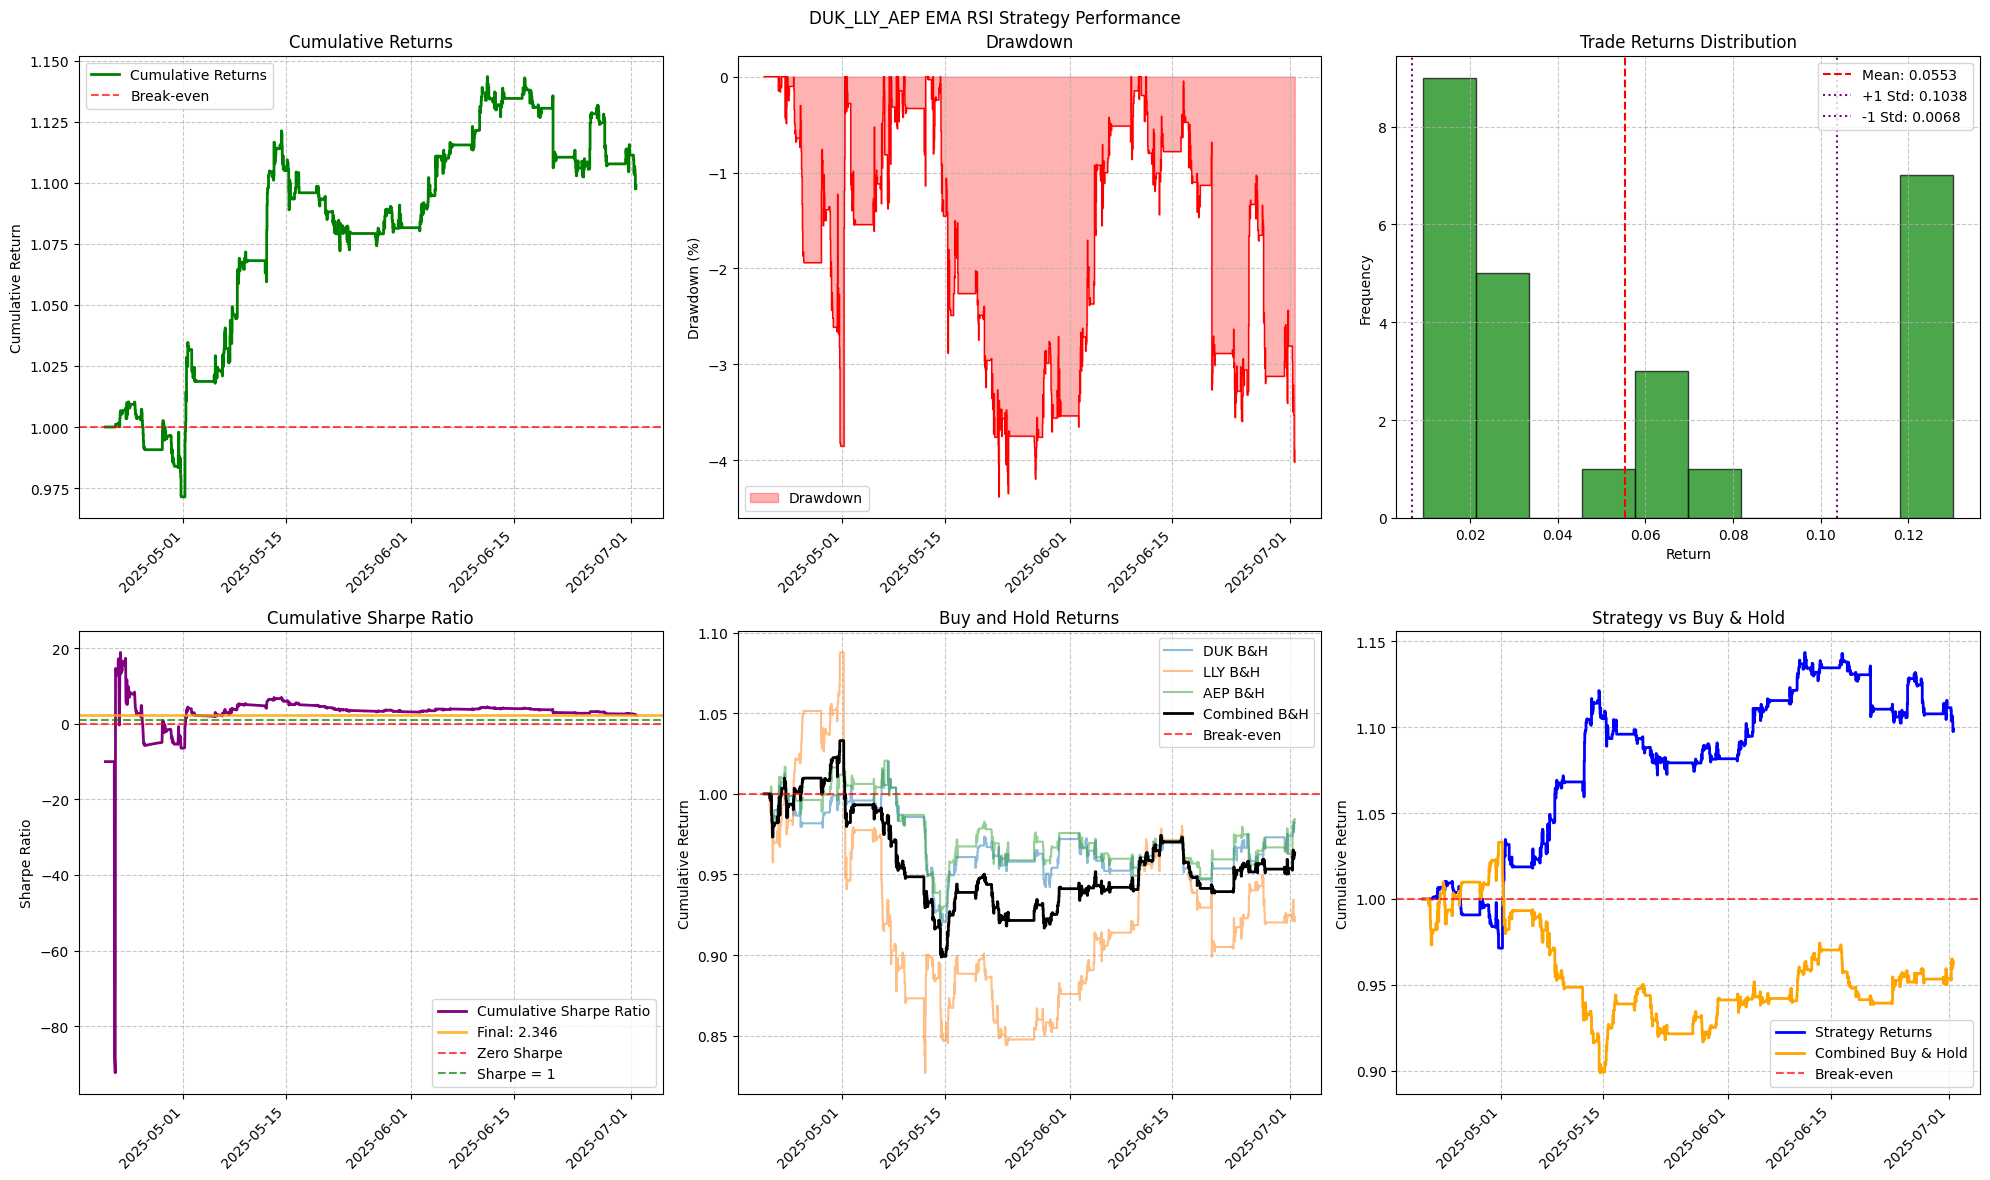

In [5]:
# Plot the results
print("plotting...")
backtester.plot_performance_analysis(
    title="_".join(symbols) + " EMA RSI Strategy Performance", show_plot=False)

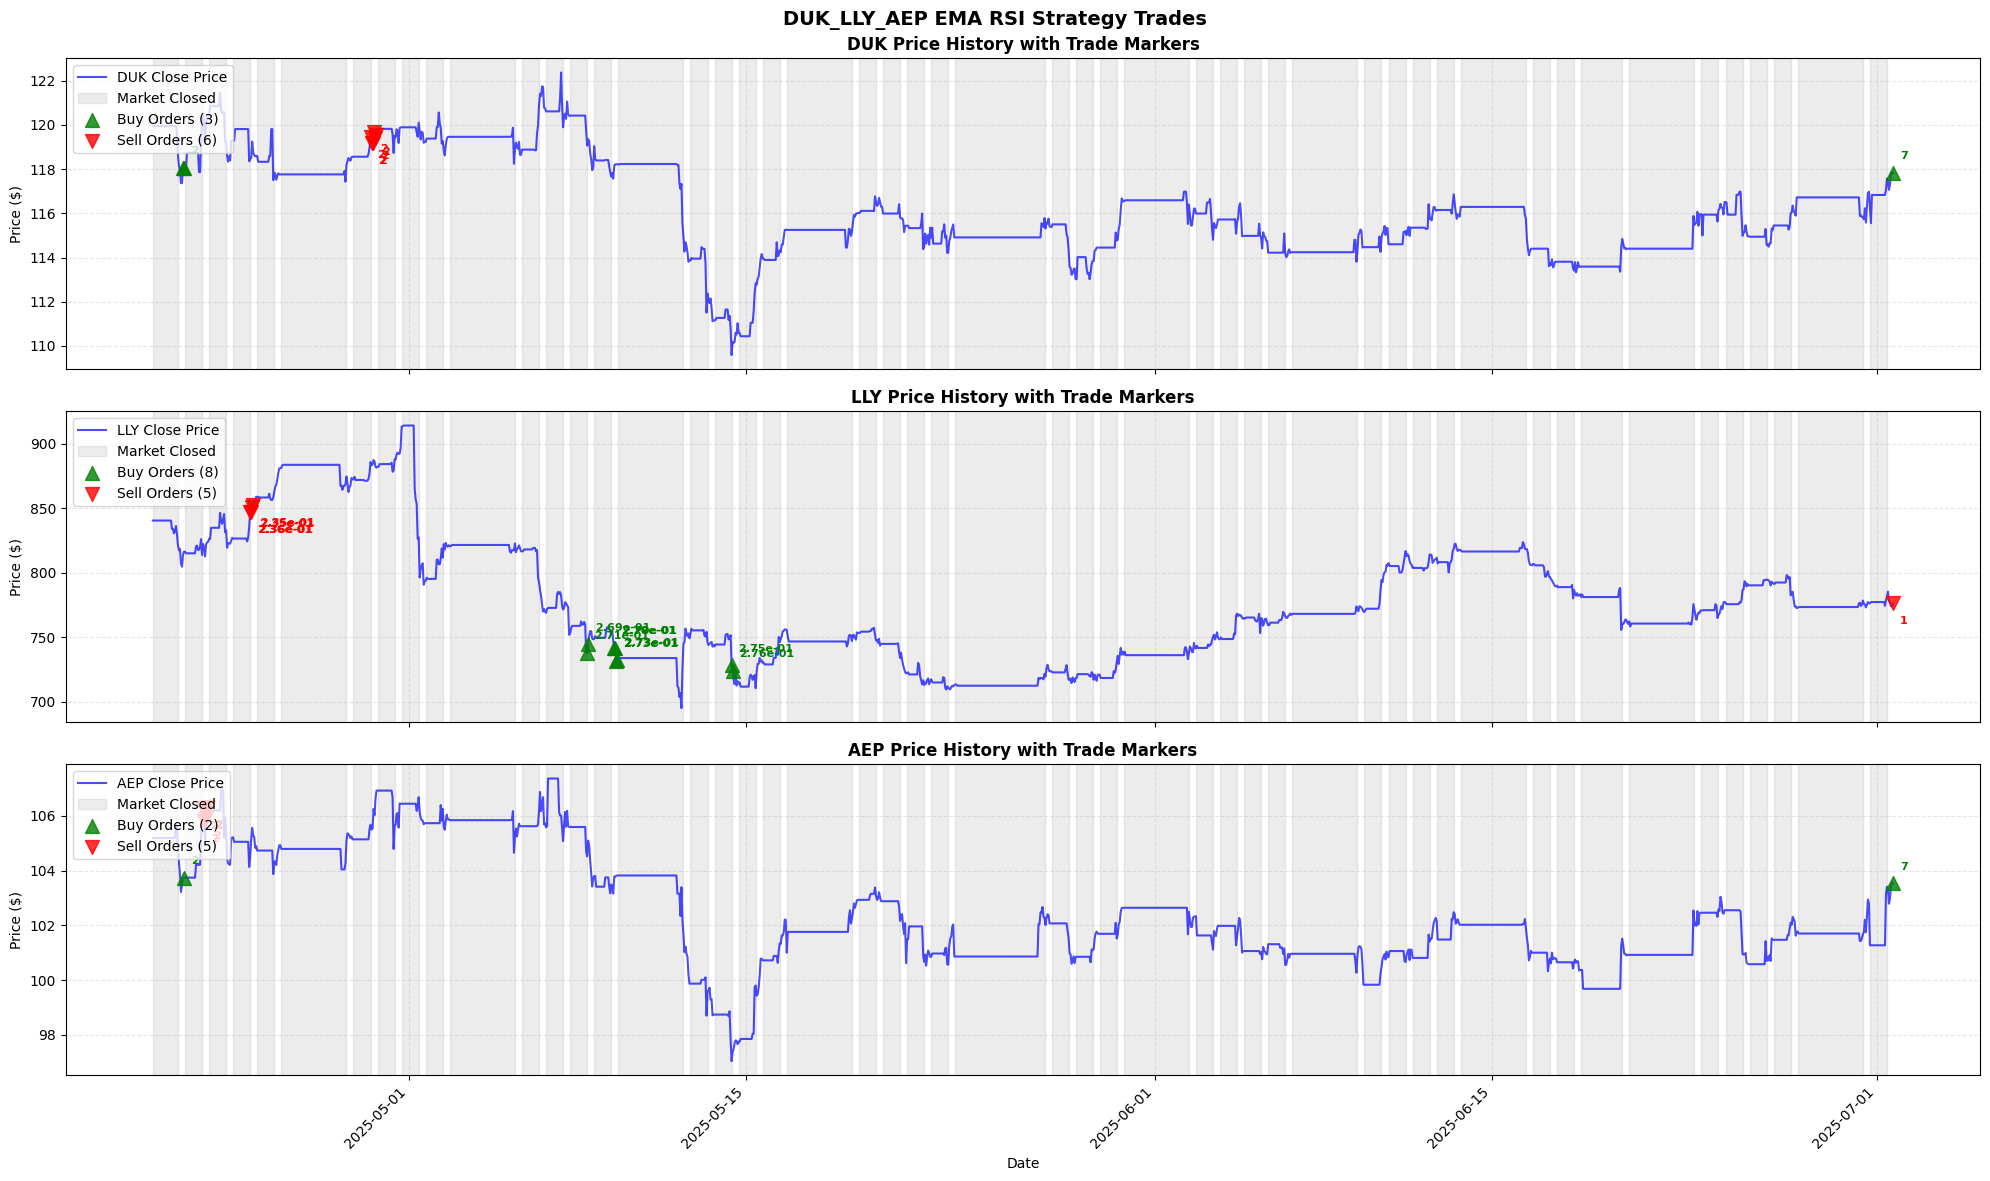

In [6]:
backtester.plot_trade_history(title="_".join(
    symbols) + " EMA RSI Strategy Trades", show_plot=False)

[2025-08-17 20:13:33][INFO] Auto-calculated periods per year: 8766 (avg time diff: 3600.0 seconds)


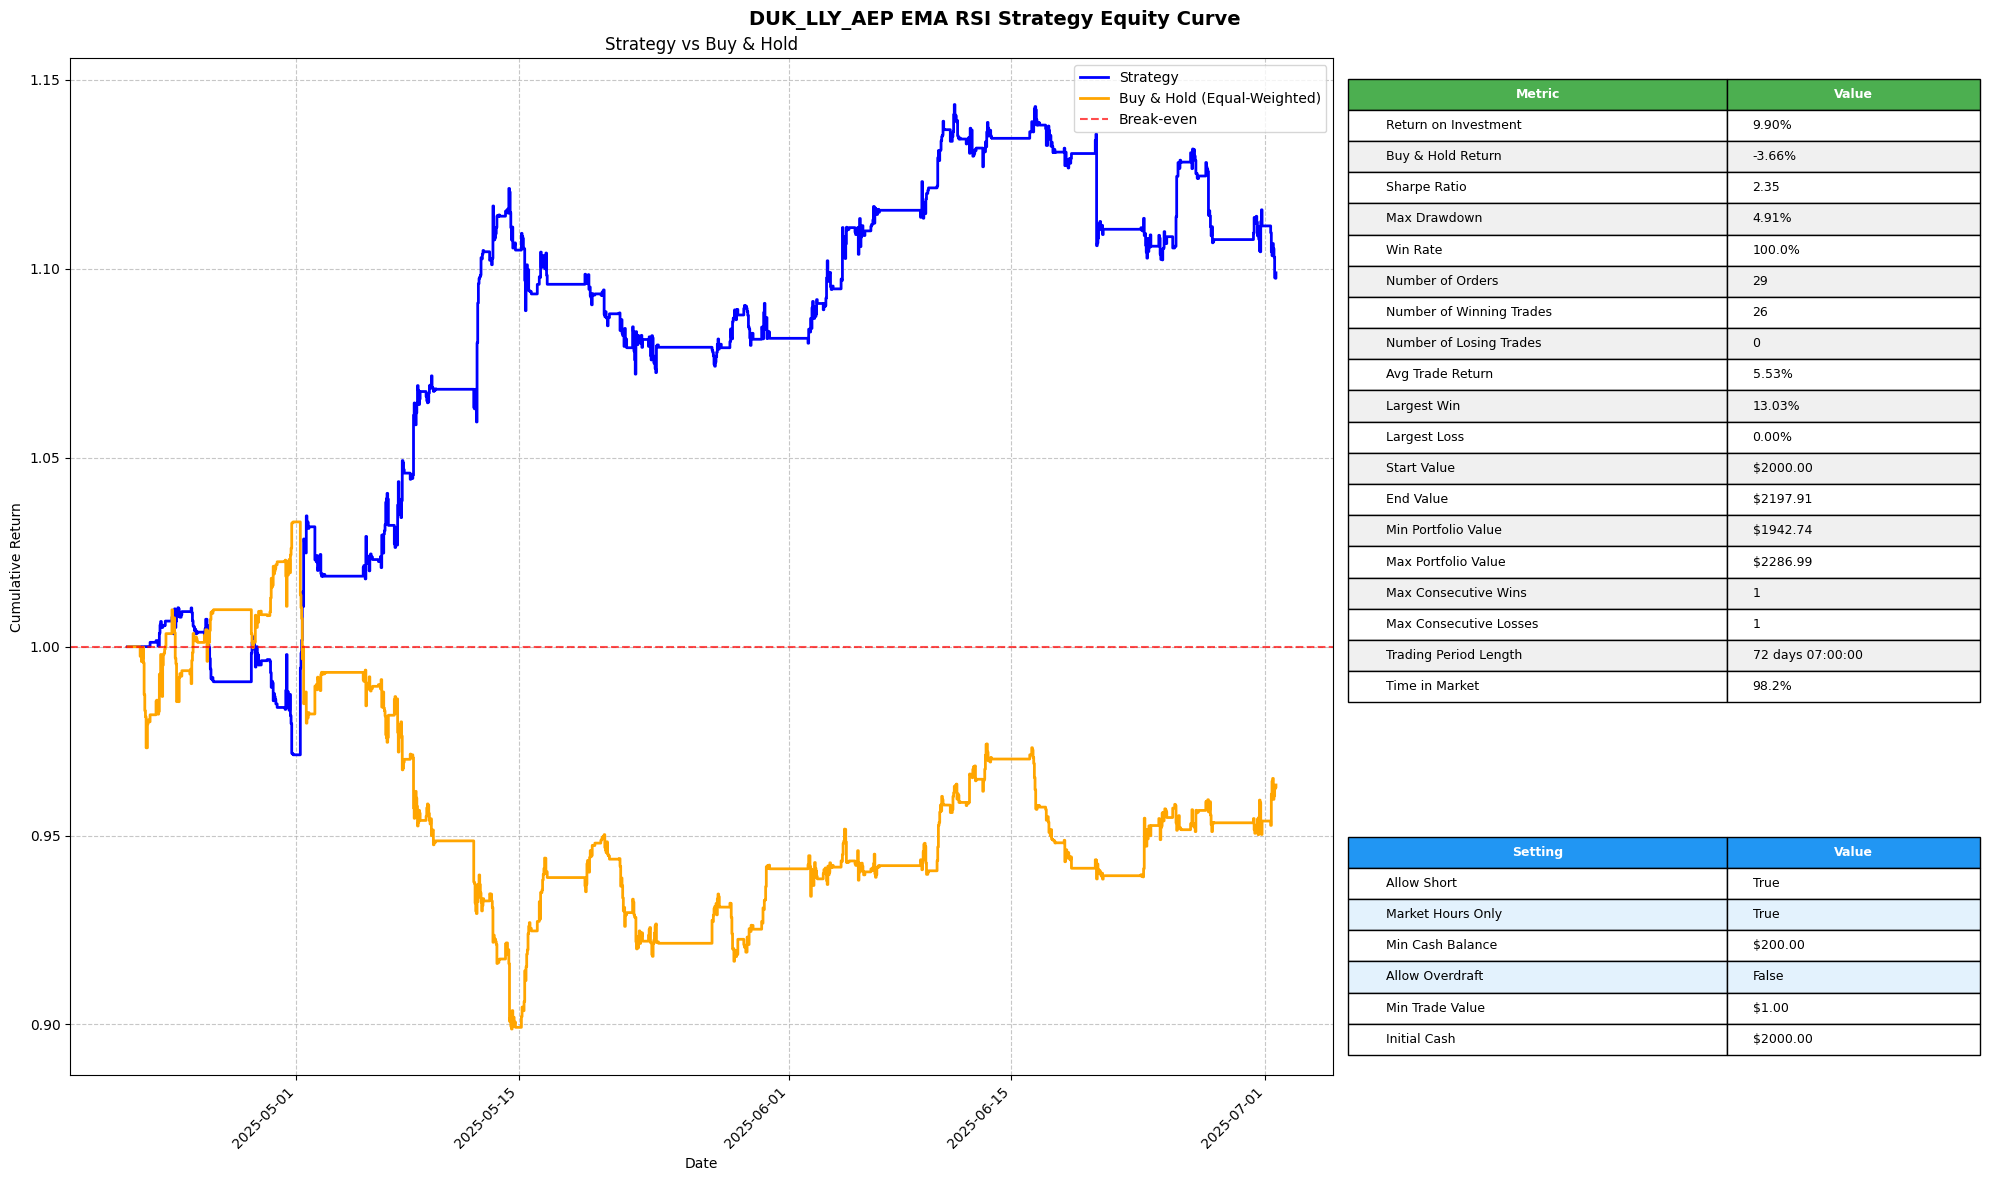

In [7]:
backtester.plot_equity_curve(
    title="_".join(symbols) + " EMA RSI Strategy Equity Curve", show_plot=False
)